## Get the top 5 users with the most time spent on the web.

In [1]:
%matplotlib inline
%reload_ext sql
%config SqlMagic.autolimit=0

In [5]:
import os

# sqlalchemy Imports
from sqlalchemy import (
    create_engine, MetaData, Table, select
)
from sqlalchemy.sql import func, desc, case, cast
from sqlalchemy.engine import Connection
from sqlalchemy.sql.expression import join

# Graphing Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Customize Matplotlib styles
plt.style.use(['ggplot'])

### Database setup.

In [6]:
# Database Constants
DB_CRED = os.getenv('DB_CRED', '')
DB_PATH = os.getenv('DB_PATH', '')
DB_FULL_PATH = 'postgres://{cred}{path}'.format(cred=DB_CRED, path=DB_PATH)
%sql $DB_FULL_PATH

'Connected: mhcpkrfcznzfwq@ddbt5r9q62hbbl'

In [7]:
# Create engine, connection & metadata object.
engine = create_engine(DB_FULL_PATH)
connection = Connection(engine).connect()
metadata = MetaData()

### Display database tables.

In [8]:
print(engine.table_names())

['alembic_version', 'account', 'host', 'time', 'host_time']


### Reflect database.

In [9]:
# Reflect all of the tables.
time = Table('time', metadata, autoload=True, autoload_with=engine)
host = Table('host', metadata, autoload=True, autoload_with=engine)
account = Table('account', metadata, autoload=True, autoload_with=engine)
host_time = Table('host_time', metadata, autoload=True, autoload_with=engine)

### Display each tables columns.

In [10]:
# Print each tables columns.
print('Print out each table columns:')
print('time table:      {columns}'.format(columns=time.columns))
print('host table:      {columns}'.format(columns=host.columns))
print('account table:   {columns}'.format(columns=account.columns))
print('host_time table: {columns}'.format(columns=host_time.columns))

Print out each table columns:
time table:      ['time.id', 'time.day', 'time.seconds', 'time.account_id']
host table:      ['host.id', 'host.host_name']
account table:   ['account.id', 'account.token']
host_time table: ['host_time.time_id', 'host_time.host_id']


### Get top 5 users based on most time spent.

In [11]:
%%sql 
SELECT account.id as users, sum(time.seconds) as seconds FROM account
JOIN time on account.id = time.account_id
GROUP BY account.id
ORDER BY seconds DESC
LIMIT 5

5 rows affected.


users,seconds
1,758151
5,624519
2,475324
4,33094
3,7743


### Query the database to get all unique visits per host name.

In [12]:
%%sql
SELECT host.host_name as "websites", count(host.host_name) as "total visits" from host
JOIN host_time on host.id = host_time.host_id
GROUP BY host.host_name
HAVING count(host.host_name) > 25
ORDER BY "total visits" DESC

49 rows affected.


websites,total visits
newtab,1456
google.com,1141
localhost,915
docs.google.com,704
youtube.com,416
facebook.com,370
mail.google.com,370
github.com,341
stackoverflow.com,212
searchincognito.com,165


### Create DataFrame from sql query results.

In [13]:
results = _
df = pd.DataFrame(data=results, columns=results.keys)
df = df.set_index('websites')

### Create graph showing top 5 websites visited.

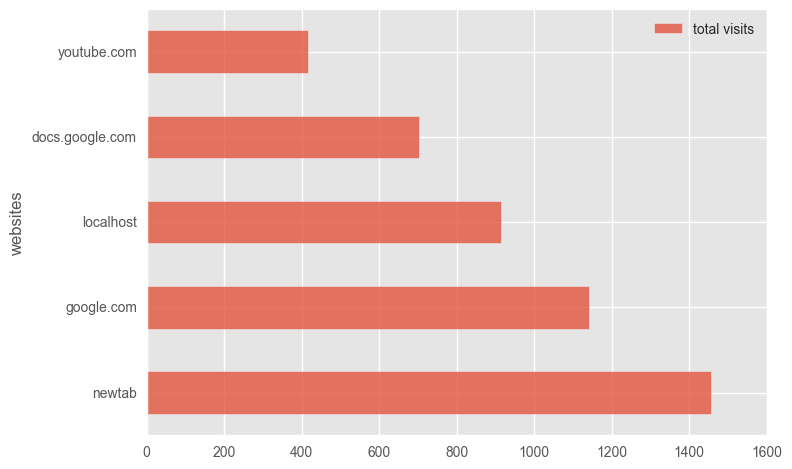

In [14]:
df[:5].plot(kind='barh', alpha=0.75)

### Create a pie chart to display data differently.

([<matplotlib.patches.Wedge at 0x10ac275f8>,
  <matplotlib.text.Text at 0x10ac876d8>])

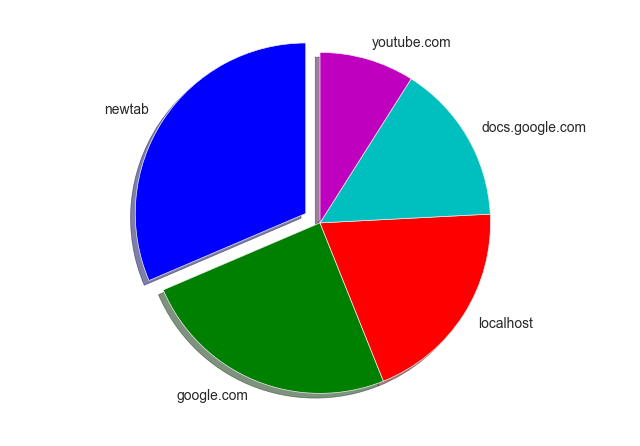

In [15]:
top_5_host_names = df.index[:5].values

# Math to get proper percentages.
arr_total_visits = np.array(df['total visits'][:5].values)
sum_total_visits = np.sum(arr_total_visits)
arr_total_percen = arr_total_visits / sum_total_visits * 100

# Options.
explode = (0.1, 0, 0, 0, 0)
plt.axis('equal')


plt.pie(x=arr_total_percen, explode=explode, labels=top_5_host_names, shadow=True, startangle=90)

### Get users activity spent over time.

In [16]:
%%sql
SELECT time.account_id as "User", time.day as "Date", COUNT(host.host_name) as "Visits" from host_time
INNER JOIN time on host_time.time_id = time.id
INNER JOIN host on host_time.host_id = host.id
GROUP BY time.day, time.account_id
ORDER BY time.day;

116 rows affected.


User,Date,Visits
1,2016-09-26,233
2,2016-09-26,14
1,2016-09-27,372
2,2016-09-27,90
2,2016-09-28,24
1,2016-09-28,114
1,2016-09-29,425
2,2016-09-29,2
2,2016-09-30,245
1,2016-09-30,388


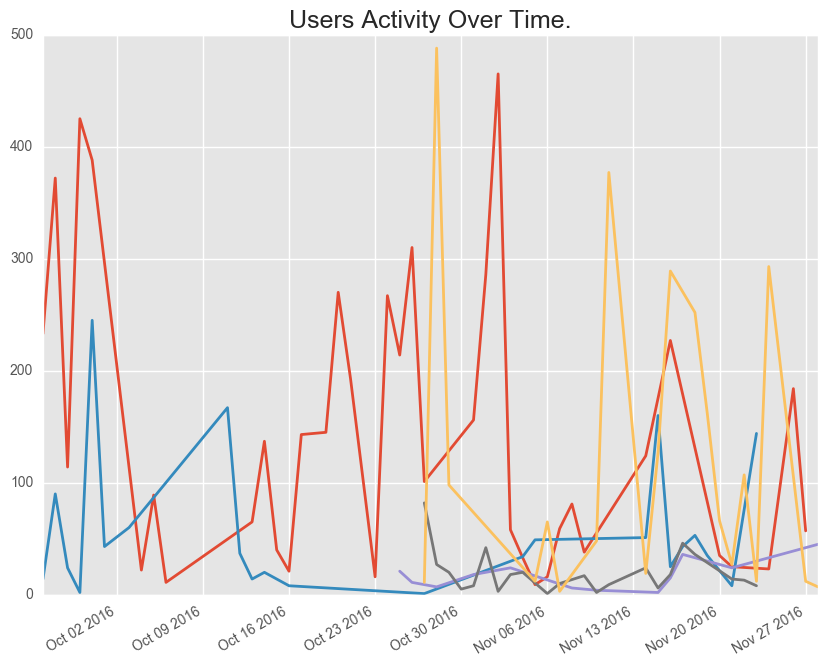

In [17]:
results = _
df = pd.DataFrame(data=results, columns=results.keys)
df['Date'] = [np.datetime64(date) for date in df['Date']]
df.set_index('Date', inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
fig.autofmt_xdate()
for i in range(1, df.User.max() + 1):
    user = df[df['User'] == i]
    line = plt.plot(
        user.index.values,
        user['Visits'],
        lw=2
    )
    
plt.title('Users Activity Over Time.', fontsize=18, ha='center')
plt.show()

### Histogram showing visits per website per day.

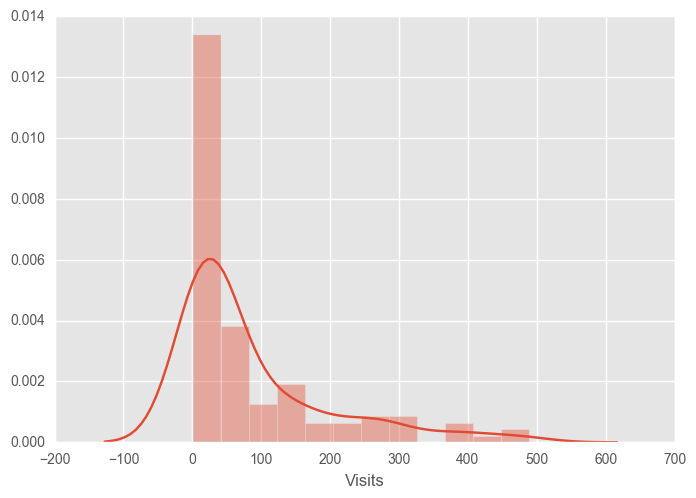

In [20]:
sns.distplot(df['Visits'])